In [ ]:
!pip3 install -q keras-core --upgrade

In [ ]:
!pip3 install --upgrade keras-nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.8 MB/s eta 0:00:00


## **Import Libraries**

In [ ]:
import keras_nlp

Using TensorFlow backend


In [ ]:
import torch

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras_core as keras
import keras_core.backend as K

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)
print("TensorFlow version:", tf.__version__)

Keras: 0.1.7
KerasNLP: 0.7.0
TensorFlow version: 2.15.0


**Setting Configuration**

In [ ]:
class CFG:
    verbose = 0  # Verbosity

    wandb = True  # Weights & Biases logging
    comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description

    preset = "deberta_v3_base_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length

    device = 'TPU'  # Device

    seed = 42  # Random seed

    num_folds = 5  # Total folds
    selected_folds = [0, 1, 2]  # Folds to train on

    epochs = 3 # Training epochs
    batch_size = 3  # Batch size
    drop_remainder = True  # Drop incomplete batches
    cache = True # Caches data after one iteration, use only with `TPU` to avoid Out of memory issues

    scheduler = 'cosine'  # Learning rate scheduler

    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

In [ ]:
keras.utils.set_random_seed(CFG.seed)

In [ ]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [ ]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on CPU


# **Loading training data**

<ipython-input-10-43e9fc43eb4e>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


# Train Data: 1378
# Sample:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


,id,text,label,source,fold,name
597,70d7c567,Can you imagine living in a place where there ...,0,,1,real
700,81977e6c,Limiting car usage could have many advantages ...,0,,4,real
1222,e43869b8,"In this generation, our planet is getting filt...",0,,4,real
1145,d33eca96,Cars are a basic need for people today we use ...,0,,4,real


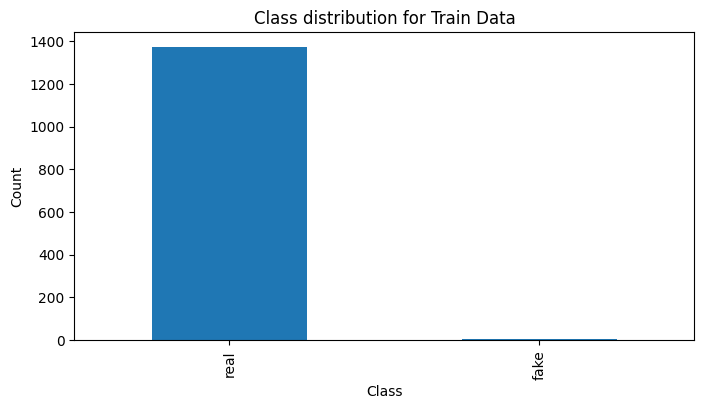

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train_essays.csv')  # Read CSV file into a DataFrame

#creating new columns in the dataset
train_df['label'] = train_df.generated.copy() #label column is same as generated column
train_df['name'] =train_df.generated.map(CFG.label2name)  # Map answer labels using name-to-label mapping
train_df["source"] =''


columns_to_delete = ['generated', 'prompt_id']
train_df = train_df.drop(columns=columns_to_delete)

# Get the 'coolwarm' colormap from matplotlib
cmap = mpl.cm.get_cmap('coolwarm')

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

train_df = train_df.reset_index(drop=True)  # Reset dataframe index

train_df["fold"] = -1  # New 'fold' column

# Assign folds using StratifiedKFold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    train_df.loc[val_idx, 'fold'] = fold

current_order1 = ['id', 'text','label','name','source','fold']

# Desired order of columns
desired_order1 =['id', 'text', 'label','source','fold','name']

# Create a new DataFrame with columns in the desired order
train_df= train_df[desired_order1]

# Display information about the train data
print("# Train Data:",len(train_df))#display no. of rows in the dataset
print("# Sample:",)
display(train_df.sample(4))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
train_df.name.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()

# **Load external Data**

In [ ]:
# Load external data
ext_df1 = pd.read_csv('/content/drive/MyDrive/train_drcat_04.csv')
ext_df2 = pd.read_csv('/content/drive/MyDrive/argugpt.csv')[['id','text','model']] #consider only 3 columns from this dataset

ext_df2.rename(columns={'model':'source'}, inplace=True)
ext_df2['label'] = 1

ext_df1.rename(columns={'essay_id':'id'}, inplace=True)
ext_df1= ext_df1.drop('prompt', axis=1)

# concatenates a sample of 10,000 rows from ext_df1 where the 'source' column is equal to 'persuade_corpus' and all rows from ext_df1 where the
#'source' column is not equal to 'persuade_corpus'.

ext_df1 = pd.concat([
    ext_df1[ext_df1.source=='persuade_corpus'].sample(10000),
    ext_df1[ext_df1.source!='persuade_corpus'],
])

current_order = ['id', 'text', 'source','label']

# Desired order of columns
desired_order =['id', 'text', 'label','source']

# Create a new DataFrame with columns in the desired order
ext_df2= ext_df2[desired_order]

In [ ]:
from sklearn.model_selection import StratifiedKFold  # Import package

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

ext_df2 = ext_df2.reset_index(drop=True)  # Reset dataframe index

ext_df2['stratify'] = ext_df2.label.astype(str)+ext_df2.source.astype(str)

ext_df2["fold"] = -1  # New 'fold' column

# Assign folds using StratifiedKFold
for fold, (train_idx, val_idx) in enumerate(skf.split(ext_df2, ext_df2['stratify'])):
    ext_df2.loc[val_idx, 'fold'] = fold

ext_df2=ext_df2.drop('stratify',axis=1)


In [ ]:

ext_df1['name'] = ext_df1.label.map(CFG.label2name)
ext_df2['name'] = ext_df2.label.map(CFG.label2name)

display(ext_df1.sample(5))
display(ext_df2.sample(5))

,id,text,label,source,fold,name
26533,B4994C771190,Do you think that students would benefit from ...,0,original_moth,9,real
6175,F1883C3A8C1E,"Sure, here's my attempt at writing an essay re...",1,llama2_chat,1,fake
37437,ED8E7F6A56DD,"Hey there! So, you wanna know about them fanc...",1,llama2_chat,7,fake
17171,D0028C081AAE,"Dear, MR Principal\n\nOw dear Mr Principal I t...",0,persuade_corpus,7,real
16680,llama_70b_v1995,I think the minimum wage should be raised in m...,1,llama_70b_v1,7,fake


,id,text,label,source,fold,name
1878,toefl_744,It is certainly true that young people nowaday...,1,text-davinci-001,2,fake
3781,weccl_2792,As the cost of higher education continues to r...,1,gpt-3.5-turbo,4,fake
223,weccl_451,Education is not a life-long process. It is a ...,1,text-davinci-001,3,fake
394,weccl_495,There are many different opinions on whether c...,1,text-davinci-001,4,fake
3461,weccl_2721,I agree with the African proverb that if you e...,1,text-davinci-003,4,fake


# External Data: 32248
# Sample:


,id,text,label,source,fold,name
9289,llama_70b_v1107,Gun control is a really big issue and it's sup...,1,llama_70b_v1,9,fake
27721,A9FC7416BFC4,"During the summer, students want to play video...",0,persuade_corpus,4,real
3909,A1C3D4F6E4D8,Sixty-seven percent of people who seek multipl...,0,persuade_corpus,9,real
19658,69241D10E69A,The advent of online school has ushered in a n...,1,chat_gpt_moth,8,fake
35986,715ECA916439,"Dear Principal,\n\nI believe that community se...",0,persuade_corpus,2,real


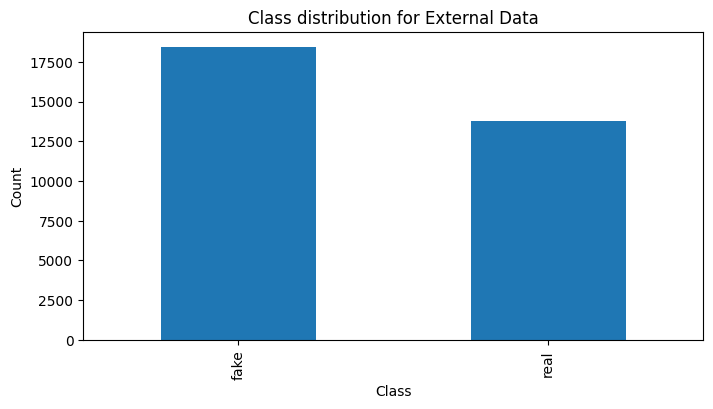

In [ ]:

ext_df= pd.concat([ext_df1, ext_df2], axis=0)

# Display information about the external data
print("# External Data:",len(ext_df))
print("# Sample:")
display(ext_df.sample(5))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
ext_df.name.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for External Data")
plt.show()

**Concatenating training and external datasets**

# Total Data: 33626
# Sample:


,id,text,label,source,fold,name
27868,falcon_180b_v1_438,Homework has been a topic of debate for many y...,1,falcon_180b_v1,0,fake
14045,767920BDAD93,"In today's fast-paced world, students often f...",1,mistral7binstruct_v2,1,fake
3765,399134D6E1E8,The Electoral College is a system where electe...,0,persuade_corpus,7,real
153,weccl_742,University education is a crucial stage in the...,1,gpt-3.5-turbo,0,fake
33269,93385DED39E7,Some schools offer distance learning as an opt...,0,persuade_corpus,5,real


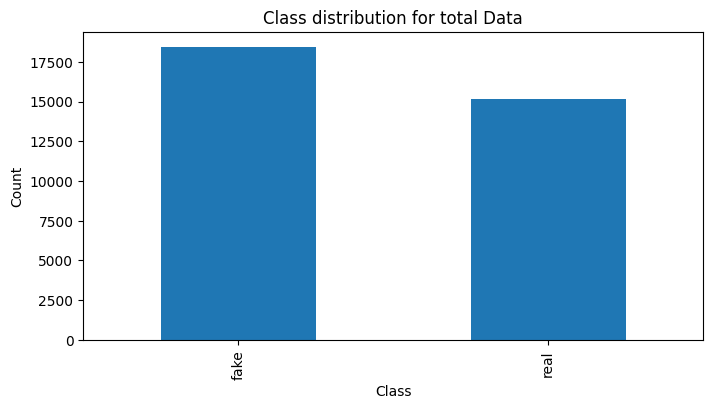

In [ ]:
#concatenating external dataset and training dataset.

df= pd.concat([ext_df,train_df], axis=0)

# Display information
print("# Total Data:",len(df))
print("# Sample:")
display(df.sample(5))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.name.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for total Data")
plt.show()

In [ ]:
df = df.sample(n=50, random_state=42)  # Set random_state for reproducibility

# If you want to reset the index of the new DataFrame
df = df.reset_index(drop=True)


# 🍽️ | **Preprocessing**


 The preprocessor takes input strings and transforms them into a dictionary (token_ids, padding_mask) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming "The quick brown fox" into ["the", "qu", "##ick", "br", "##own", "fox"], we simplify the data. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

preprocessor is instance(object) of the DebertaV3Preprocessor class using a predefined preset
It can be used to preprocess data according to the specified configuration. Typically, this involves tokenizing and formatting text data in a way suitable for input to the model.








The `DebertaV3Preprocessor` is a part of the `keras_nlp` library and is specifically designed for preprocessing data when working with the DeBERTa V3 model. The preprocessing step is crucial when dealing with natural language processing (NLP) models, as it transforms raw text data into a format suitable for input to the neural network.


   - Tokenization involves breaking down a sequence of text into smaller units called tokens. These tokens are usually words or subwords, and they form the basic units of input for the model.

   - The preprocessor may handle additional formatting steps, such as converting tokens to numerical representations, padding or truncating sequences to a fixed length, and incorporating special tokens for tasks like classification or language modeling.



In [ ]:

preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter and truncated if longer
)

INFO:kagglehub.clients:Downloading from https://www.kaggle.com/api/v1/models/keras/deberta_v3/keras/deberta_v3_base_en/2/download/tokenizer.json...
100%|██████████| 424/424 [00:00<00:00, 191kB/s]
INFO:kagglehub.clients:Downloading from https://www.kaggle.com/api/v1/models/keras/deberta_v3/keras/deberta_v3_base_en/2/download/assets/tokenizer/vocabulary.spm...
100%|██████████| 2.35M/2.35M [00:00<00:00, 127MB/s]


In [ ]:
inp = preprocessor(df.text.iloc[0])  # Process text for the first row

#inp is the dictionary with key-value pair as k and v where v is the processed text.

# Display the shape of each processed output

# Prints the key, a colon, and the shape of the processed output (v).
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (200,)
padding_mask : (200,)


In [ ]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

In [ ]:
#The build_dataset function is designed to create a TensorFlow dataset from input texts and labels

def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices -- tuples of text and label.
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices

#Caching a dataset refers to storing the elements of the dataset in memory or on disk so that they can be quickly retrieved during subsequent iterations.
# This can significantly improve training performance in certain scenarios.
#When a dataset is cached, the data is read and processed once, and the results are stored for reuse.
#During subsequent epochs or iterations, instead of re-reading and processing the data from the original source (e.g., files on disk),TensorFlow fetches the
# preprocessed data from the cache. This avoids redundant data processing and can lead to faster training times.

    ds = ds.cache() if cache else ds  # Cache dataset if enabled

    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function to each element in the dataset, applying text preprocessing.
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled

    # creating a tf.data.Options object allows to configure various options for a TensorFlow dataset.
    opt = tf.data.Options()  # opt is an instance of tf.data.Options class

    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False

    ds = ds.with_options(opt)  #  applies the options stored in the opt instance to the dataset ds.

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    #Batches the dataset into batches of size batch_size. The drop_remainder parameter determines whether to drop the last batch if it has fewer elements than batch_size.

    ds = ds.prefetch(AUTO)
# prefetch elements from the dataset, enabling the model to asynchronously fetch batches of data while the current batch is being processed.
# This can help to reduce the overall training time by overlapping the data loading and model training steps.
#AUTO determines the number of batches to prefetch. Using AUTOTUNE allows TensorFlow to dynamically adjust this value based on the execution environment.

    return ds  # Return the built dataset

In [ ]:
def get_datasets(fold):
  #Get training fold data
  #Selects rows from the DataFrame df where the 'fold' column does not have the specified value fold.sample(frac=1) shuffles the selected training data to ensure randomness (frac=1 means to use the entire dataset).
    train_df1 = df[df.fold!=fold].sample(frac=1)

    train_texts = train_df1.text.tolist()  # Extract training texts
    train_labels = train_df1.label.tolist()  # Extract training labels

    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True)

     #Selects rows from the DataFrame df where the 'fold' column has the specified value fold.sample(frac=1) shuffles the selected training data to ensure randomness (frac=1 means to use the entire dataset).

    valid_df = df[df.fold==fold].sample(frac=1)  # Get validation fold data
    valid_texts = valid_df.text.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels

    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False)

    return (train_ds, train_df1), (valid_ds, valid_df)  # Return datasets and dataframes

# **🪄 | Wandb**

Weights & Biases

To monitor the training of my text-based model, I'll make use of Weights & Biases. Weights & Biases (W&B) is an MLOps platform that offers experiment tracking, dataset versioning, and model management functionalities, aiding in efficient model development.

In [ ]:
!pip install --upgrade -q wandb git+https://github.com/soumik12345/wandb-addons

In [ ]:
!pip install --upgrade wandb


In [ ]:
import wandb

# Check if the WANDB_API_KEY environment variable is set
api_key ="4e80bf1a94f7dbaf85332a2c9e0413e2648498ad"

if api_key:
    wandb.login(key=api_key)  # Login to wandb with the API key
    anonymous = None  # Set anonymous mode to None
else:
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)  # Login to wandb anonymously and relogin if needed

In [ ]:

# Initializes the W&B run with a config file and W&B run settings.
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary containing configuration parameters from CFG (excluding those with '__' in the name).
    config.update({"fold": int(fold)})  # Add fold to config dictionary with key as fold and value as fold which is given as a parameter.

    #start a new run
    run = wandb.init(project="llm-fake-text",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

# Logs the best results (AUC, loss, and epoch) to wandb for later analysis.
def log_wandb():
    wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr]  # Return WandB callbacks

## **Learning rate scheduler**

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at lr_start and gradually tapers down to lr_min using various techniques, including:

step: Lowering the learning rate in step-wise manner resembling stairs.

cos: Utilizing a cosine curve to gradually reduce the learning rate.

exp: Exponentially decreasing the learning rate.

Importance: A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [ ]:
import math

# callback is used to adjust the learning rate during training based on different LR scheduling modes -linear ramp-up, cosine annealing, exponential decay, and step decay.
#mode is LR scheduling mode
#plot-- whether to plot LR schedule plot or not
#default values are mentioned below
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False): # learning rate (LR) callback function
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75

# - Learning Rate Schedule:
#   - The learning rate (`lr`) is initially set to `lr_start` (0.6e-6) and gradually increases to `lr_max` (0.5e-6 * batch_size) during the "ramp-up" phase, which lasts for `lr_ramp_ep` (1) epoch.
#   - Subsequently, the learning rate remains constant (`lr_max`) during the "sustain" phase, which lasts for `lr_sus_ep` (0) epochs.
#   - Finally, during the "decay" phase, the learning rate undergoes a cosine annealing decay from `lr_max` to `lr_min` (0.3e-6) over the remaining epochs (`lr_decay` = 0.75 * total epochs).


    def lrfn(epoch):  # Learning rate update function  epoch: The current epoch during the training process.
        if epoch < lr_ramp_ep: lr = (epoch*(lr_max - lr_start) / lr_ramp_ep) + lr_start #this is ramp up phase where lr changes from lr_start to lr_max linearly.
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max #this is sustain phase where lr remains lr_max.
        #now we have decay phase where lr changes from lr_max to lr_min depending on the mode .
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min #exponential decay
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2) #step decay
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep #cosine annealing decay
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    #This returns a Learning Rate Scheduler callback, created using the keras.callbacks.LearningRateScheduler class in TensorFlow Keras.The learning rate update function lrfn is passed as an argument to the LearningRateScheduler.
    #"verbose" typically refers to the level of detail or amount of information displayed during the execution of a program
    #setting verbose to False means that detailed information about the learning rate updates will not be printed or displayed during the training process.

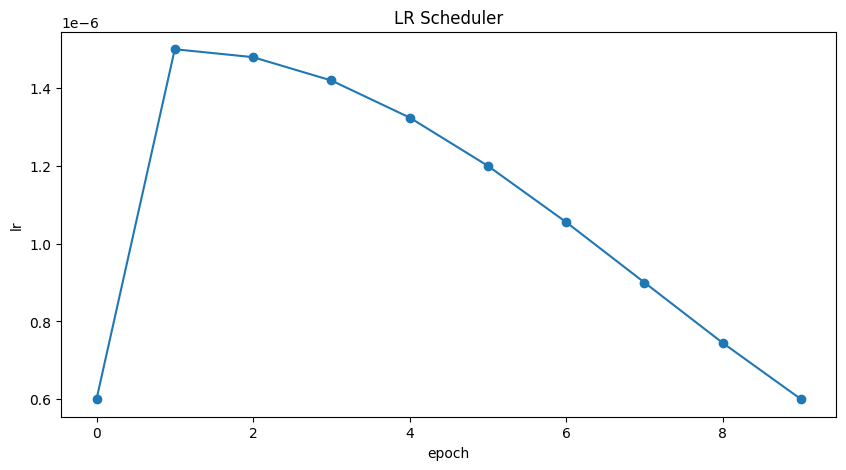

In [ ]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

## **Callbacks**

In [ ]:
#The function gathers all the training callbacks, such as lr_scheduler, model_checkpoint, wandb_logger
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)  # Get lr callback
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor='val_auc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks
    #callbacks.extend([ckpt_cb])

    if CFG.wandb:  # If WandB is enabled
        wandb.init()
        wb_cbs = get_wb_callbacks(fold)  # Get WandB callbacks
        callbacks.extend(wb_cbs) #add wandb callbacks

    return callbacks  # Return the list of callbacks

# - ModelCheckpoint Parameters:
#   - `filepath`: The first argument specifies the file path where the model weights will be saved. In this case, it uses an f-string to include the fold number in the file name, creating a unique checkpoint file for each fold.
#   - `monitor`: The parameter `monitor='val_auc'` specifies the metric to monitor for saving the best model. In this case, it monitors the validation AUC (Area Under the Curve) metric.
#   - `save_best_only`: The parameter `save_best_only=True` indicates that only the best models, those that improve on the monitored metric, will be saved.
#   - `save_weights_only`: The parameter `save_weights_only=False` indicates that the entire model, including both architecture and weights, will be saved. If set to `True`, only the model's weights would be saved.
#   - `mode`: The parameter `mode='max'` specifies that the checkpoint will be saved when the monitored metric is maximized. In this case, it saves the model when the validation AUC reaches its maximum value.

# The purpose of the ModelCheckpoint callback is to save the model's weights at specific points during training, allowing you to later restore the best-performing model.
# In this case, it saves the model with the highest validation AUC, ensuring that the saved model is the one that performs the best on the specified metric.

## **Model**

The KerasNLP library provides comprehensive, ready-to-use implementations of popular NLP model architectures. It features a variety of pre-trained models including Bert, Roberta, DebertaV3, and more. I will use DebertaV3 model.

My approach involves using keras_nlp.models.XXClassifier to process each text and generatie logits. These logits are passed through a softmax function to produce the final output.

In [ ]:
def build_model(features, labels,fold):

    # Pretrained classifier.
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
       CFG.preset,
       num_classes=1,
       preprocessor=keras_nlp.models.DebertaV3Preprocessor.from_preset(
        preset=CFG.preset, # Name of the model
        sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter and truncated if longer
       )
    )

    if CFG.wandb:
        run = wandb_init(fold)

    # Compile the model
    classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer='adam',  # Use the string identifier for the optimizer
        jit_compile=True,
        metrics=[
            tf.keras.metrics.AUC(name="auc"),
        ],
    )

    # Fit again.
    classifier.fit(x=features, y=labels, batch_size=2, epochs=CFG.epochs,
       # validation_data=valid_ds,
       callbacks=get_callbacks(fold),
       steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas), # number of batches processed per epoch
       )

    # Access backbone programmatically (e.g., to change `trainable`).
    classifier.backbone.trainable = False

    # Find the epoch with the best validation accuracy
    best_epoch = np.argmax(classifier.history.history['auc'])   #model.history.history == training history of the model
    #returns the index of the maximum value-- it finds the epoch with the highest validation AUC.
    best_auc = classifier.history.history['auc'][best_epoch]
    best_loss = classifier.history.history['loss'][best_epoch]

    # Print and display best results
    print(f'\n{"=" * 17} FOLD {fold} RESULTS {"=" * 17}')
    print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST AUC   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
    print('=' * 50)

    # Log best result on Weights and Biases (wandb) if enabled
    if CFG.wandb:
        wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})  # Log results
        wandb.run.finish()  # Finish the run
#         display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard
    print("\n\n")

    return classifier

In [ ]:
for fold in CFG.selected_folds:
   (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)

     # Print training information
   print('#' * 50) #prints 50 # characters.
   print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
   print(f'\tNum Train: {len(train_df)} | Num Valid: {len(valid_df)}')
   print('#' * 50)

   features=train_df['text']
   labels=train_df['label']
     #Clear TensorFlow session and build the model within the strategy scope
   K.clear_session()
   with strategy.scope():
        model=build_model(features,labels,fold)


# In TensorFlow, when working with multiple GPUs or TPUs, it's common to use a distribution strategy to parallelize the training process across these devices.The `tf.distribute.Strategy`
# API provides a way to achieve this parallelization.

# - `with strategy.scope():`: This is a context manager provided by TensorFlow. Operations inside this block will be executed within the context of the distribution strategy specified by `strategy`.
# The purpose of using this context manager is to ensure that the model and its training-related operations are compatible with the chosen distribution strategy.
#  Inside the `strategy.scope()`, the `build_model()` function is called to create and compile the model. The model construction is performed within the scope of the distribution strategy.
# This is crucial for ensuring that the model is built in a way that allows it to be trained efficiently across multiple devices.

# - **Parallelization**: The distribution strategy, such as `tf.distribute.MirroredStrategy` for multi-GPU training or `tf.distribute.TPUStrategy` for TPU training,
#  handles the distribution of computation and memory management across devices.
#  It replicates the model's architecture onto each device, and during training, each replica processes a portion of the training data.
# The strategy then synchronizes the model weights across all replicas after each batch, enabling parallelization.


##################################################
	Fold: 1 | Model: deberta_v3_base_en
	Batch Size: 3 | Scheduler: cosine
	Num Train: 45 | Num Valid: 5
##################################################


INFO:kagglehub.clients:Downloading from https://www.kaggle.com/api/v1/models/keras/deberta_v3/keras/deberta_v3_base_en/2/download/config.json...
100%|██████████| 540/540 [00:00<00:00, 556kB/s]
INFO:kagglehub.clients:Downloading from https://www.kaggle.com/api/v1/models/keras/deberta_v3/keras/deberta_v3_base_en/2/download/model.weights.h5...
100%|██████████| 702M/702M [00:12<00:00, 59.2MB/s]
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_

Epoch 1/3
15/15 [==============================] - ETA: 0s - loss: nan - auc: 0.5000

15/15 [==============================] - 256s 9s/step - loss: nan - auc: 0.5000 - lr: 6.0000e-07
Epoch 2/3
 8/15 [===============>..............] - ETA: 2:11 - loss: nan - auc: 0.5000

15/15 [==============================] - 139s 9s/step - loss: nan - auc: 0.5000 - lr: 1.5000e-06

================= FOLD 0 RESULTS =================
>>>> BEST Loss  : nan
>>>> BEST AUC   : 0.500
>>>> BEST Epoch : 0


best_auc,▁
best_epoch,▁
epoch/auc,▁▁
epoch/epoch,▁█
epoch/learning_rate,▁█
epoch/lr,▁█
best_auc,0.5
best_epoch,0
best_loss,nan
epoch/auc,0.5
epoch/epoch,1





##################################################
	Fold: 2 | Model: deberta_v3_base_en
	Batch Size: 3 | Scheduler: cosine
	Num Train: 45 | Num Valid: 5
##################################################


Epoch 1/3
15/15 [==============================] - ETA: 0s - loss: nan - auc: 0.5000

15/15 [==============================] - 263s 9s/step - loss: nan - auc: 0.5000 - lr: 6.0000e-07
Epoch 2/3
 8/15 [===============>..............] - ETA: 2:03 - loss: nan - auc: 0.5000

15/15 [==============================] - 132s 9s/step - loss: nan - auc: 0.5000 - lr: 1.5000e-06

================= FOLD 1 RESULTS =================
>>>> BEST Loss  : nan
>>>> BEST AUC   : 0.500
>>>> BEST Epoch : 0


best_auc,▁
best_epoch,▁
epoch/auc,▁▁
epoch/epoch,▁█
epoch/learning_rate,▁█
epoch/lr,▁█
best_auc,0.5
best_epoch,0
best_loss,nan
epoch/auc,0.5
epoch/epoch,1





##################################################
	Fold: 3 | Model: deberta_v3_base_en
	Batch Size: 3 | Scheduler: cosine
	Num Train: 43 | Num Valid: 7
##################################################


Epoch 1/3
14/14 [==============================] - ETA: 0s - loss: nan - auc: 0.4949

14/14 [==============================] - 242s 9s/step - loss: nan - auc: 0.4949 - lr: 6.0000e-07
Epoch 2/3
 8/14 [================>.............] - ETA: 1:41 - loss: nan - auc: 0.5000

14/14 [==============================] - 128s 9s/step - loss: nan - auc: 0.5000 - lr: 1.5000e-06


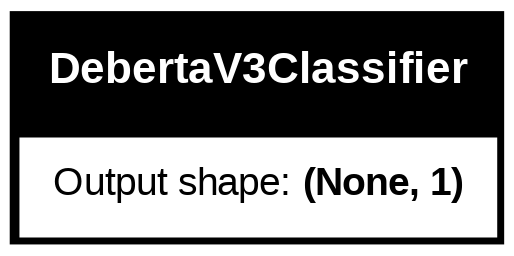

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## **Predictions**

In [ ]:
val_texts = valid_df['text'].tolist()

#Preprocess the validation data (assuming you have a preprocess_fn function)
#preprocessed_val_texts = preprocess_fn(val_texts)

# Make predictions using the trained model
predictions = model.predict(val_texts)

predicted_labels = (predictions > 0.5).astype(int)

# Print or use the predictions as needed
print(predicted_labels)


1/1 [==============================] - 7s 7s/step
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [ ]:
# Format predictions and true answers
pred_answers = (predictions > 0.5).astype(int).squeeze()
true_answers = valid_df.label.values

# predictions > 0.5:If the predicted probability is greater than 0.5, it is considered as class 1; otherwise, it is considered as class 0.
# .astype(int):Converts the boolean values obtained from the thresholding to integers. This is done to obtain the final predicted class labels.
# .squeeze():Reduces any unnecessary dimensions from the array. It's often used when dealing with arrays with a singleton dimension

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text  = row.text
    # extract the text data from the 'text' column of the i-th row in the DataFrame valid_df.
    pred_answer = CFG.label2name[pred_answers[i]]
    true_answer = CFG.label2name[true_answers[i]]
    print(f" Text {i+1}:\n{text[:100]} .... {text[-100:]}\n")
    #text[:100]: Prints the first 100 characters of the text and text[-100:]: Prints the last 100 characters of the text.
    print(f"True: {true_answer}\n")
    print(f"Predicted: {pred_answer}\n")
    print("-"*90, "\n")

# Predictions

 Text 1:
Dear Mr. Principal

The idea of making school policy that you have to have at least a grade average  .... e outside of school and those who may be thinking of coming to our school.

Sincerely,

STUDENT_NAME

True: real

Predicted: real

------------------------------------------------------------------------------------------ 

 Text 2:
On the one hand, it is possible that there will be fewer cars in use in twenty years. One reason for .... of factors, including technological advancements, environmental concerns, and urbanization trends.



True: fake

Predicted: real

------------------------------------------------------------------------------------------ 

 Text 3:
Do you think you would be able to live without your car? It would be less difficult than you think!  .... ! People have said that they feel so much happier and stress free from not using a car all the time.

True: real

Predicted: real

-------------------------------------------------------------